In [1]:
! git clone https://github.com/mrinath123/Deeplense_Gravitational_lensing.git # cloning our repo
! pip install -q timm #cloning timm for pretrained networks
! pip install -q e2cnn #for ecnn

Cloning into 'Deeplense_Gravitational_lensing'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 147 (delta 59), reused 108 (delta 33), pack-reused 0
Receiving objects: 100% (147/147), 1.52 MiB | 3.64 MiB/s, done.
Resolving deltas: 100% (59/59), done.


In [2]:
!conda install -q -y gdown #required for downlaoding datasets from google cloud

Solving environment: ...working... done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.9.14  |       ha878542_0         152 KB  conda-forge
    certifi-2022.9.14          |     pyhd8ed1ab_0         156 KB  conda-forge
    filelock-3.8.0             |     pyhd8ed1ab_0          13 KB  conda-forge
    gdown-4.5.1                |     pyhd8ed1ab_0          17 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         338 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.8.0-pyhd8ed1ab_0
  gdown              conda-forge/noarch::gdown-4.5.1-pyhd8ed1ab_0

The following packages will be UPDATED:

  ca-certificates                      2022.6.15-ha87

In [3]:
# importing important libraries
import timm
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from tqdm.notebook import tqdm
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import math
import random
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
from torch import optim
from transformers import get_cosine_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')
from sklearn import  model_selection
from e2cnn import gspaces
import e2cnn.nn as e2nn

In [4]:
# makin the repo path same as the one we are working
sys.path.insert(0, './Deeplense_Gravitational_lensing/Lensing_DomainAdaptation')

In [5]:
# importing from our repo
from models import *
from pretraining import *
from utils import *
from dataset import *
from ADDA import *

# Source Data

In [6]:
!gdown http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
!gdown http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r

Downloading...
From: http://drive.google.com/uc?id=1cRjseeUQhab5TRRb0NDmFxjGdsd0Fwo0
To: /kaggle/working/hsc2.zip
100%|█████████████████████████████████████████| 621M/621M [00:03<00:00, 177MB/s]
Downloading...
From: http://drive.google.com/uc?id=1MJ-k5xWiww6IFauu7oqqD6mzKfJiMo3r
To: /kaggle/working/hsc_lens_smooth.zip
100%|█████████████████████████████████████████| 638M/638M [00:04<00:00, 144MB/s]


In [7]:
!unzip -q hsc2.zip
!unzip -q hsc_lens_smooth.zip
cls1 = os.listdir("./hsc") # class 1 (non-lensing)
cls2 = os.listdir("./hsc_lens_smooth") # class 2 (lensing)
cls1 = ['./hsc/' + i for  i in cls1 ]
cls2 = ['./hsc_lens_smooth/' + i for  i in cls2 ]

In [8]:
cls2 = cls2[:400] # only 400 files from class 2 is used, to make the data imblalanced and match the target data, you can skip if you want

In [9]:
X_train, X_val , X_test = prep_data(cls1 , cls2) # first argument is for non-lensing images
X_train.shape , X_val.shape , X_test.shape

((27276, 2), (9093, 2), (4041, 2))

In [10]:
set_seed(42) # for reproducibility

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Augmentations

In [12]:
image_size = 64
train_aug = A.Compose(
    [  
        A.RandomCrop(32,32,p=0.5),
         A.HorizontalFlip(p=0.25),
        A.VerticalFlip(p=0.25),
        
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)
val_aug = A.Compose(
    [ 
        A.Resize(image_size,image_size,p=1.0),
        ToTensorV2()
    ]
)

# Dataloaders

In [13]:
train_data= Len(X_train,train_aug)
val_data= Len(X_val ,val_aug)


train_loader = DataLoader(train_data,
                         shuffle=True,
                    num_workers=4,
                    batch_size=64,drop_last = True,pin_memory=True)

valid_loader = DataLoader(val_data,
                         shuffle=False,
                    num_workers=4,
                    batch_size=64*2,drop_last = False ,pin_memory=True)

# Model

In [14]:
available_backbone_models()

Model Name : tf_efficientnet_b2_ns
Model Name : resnet34d
Model Name : densenet121


In [15]:
encoder = ECNN()
classifier = Classifier()
encoder = encoder.to(device)
classifier = classifier.to(device)

In [16]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [17]:
hpms = Pretraining_HPAMS()

In [18]:
print(hpms.__dict__)

{'pretraining_epochs': 7, 'pretraining_warmup_epochs': 3, 'pretraining_learning_rate': 0.0001, 'pretraining_weight_decay': 1e-05}


# Pretraining

In [19]:
supervised = PreTraining_Train(encoder,classifier,device,train_loader , valid_loader, hpms, OUTPUT_DIR,plot_metrics = True)

  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 1/7
average train_loss 0.6387643713240672
average train_auc 0.8243966826991682
average train_acc 0.6657986111111112


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.4607183732548539
avarage val_auc 0.9685546775273706
avarage val_acc 0.9772002551020408


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 2/7
average train_loss 0.29832511139337464
average train_auc 0.9384341217145724
average train_acc 0.9809816919191919


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.13013580456680182
avarage val_auc 0.988163522556718
avarage val_acc 0.9956951530612245


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 3/7
average train_loss 0.0915945537694513
average train_auc 0.9862329225150956
average train_acc 0.989226598173516


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.038873655037308226
avarage val_auc 0.9548676603048056
avarage val_acc 0.9947385204081632


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 4/7
average train_loss 0.0438095830520615
average train_auc 0.9785642097487682
average train_acc 0.99046875


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.0277433661858038
avarage val_auc 0.9949155159917058
avarage val_acc 0.9942602040816326


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 5/7
average train_loss 0.03495588978218973
average train_auc 0.9787211556595229
average train_acc 0.9901853015075377


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.0699182379306579
avarage val_auc 0.9865850156238701
avarage val_acc 0.9901147959183674


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 6/7
average train_loss 0.030782342342860706
average train_auc 0.9894031225070087
average train_acc 0.9908854166666666


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.008531249494158797
avarage val_auc 0.9980292487714876
avarage val_acc 0.9980867346938775


  0%|          | 0/426 [00:00<?, ?it/s]

For epoch 7/7
average train_loss 0.026207271276223586
average train_auc 0.9932360491543271
average train_acc 0.9910823170731707


  0%|          | 0/72 [00:00<?, ?it/s]

avarage val_loss 0.004389404006806031
avarage val_auc 0.9976958594461405
avarage val_acc 0.9992028061224489


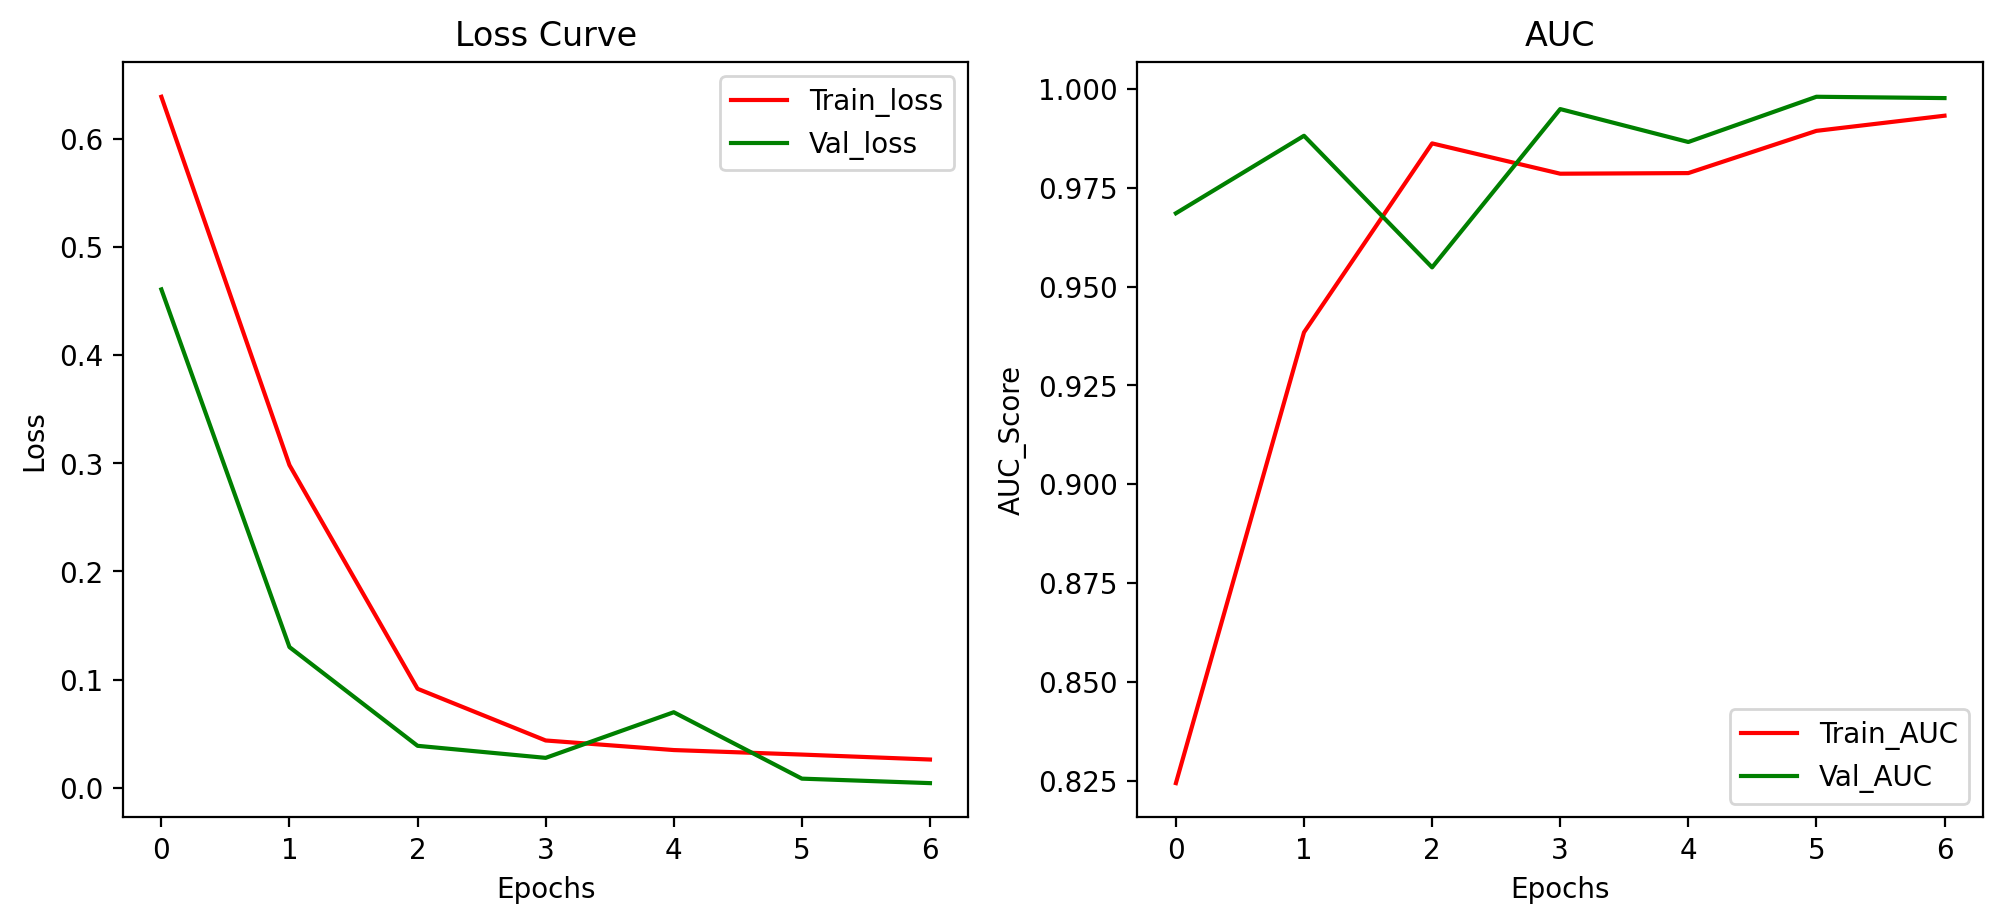

In [20]:
supervised.train()

In [21]:
test_data = Len(X_test ,val_aug)
test_loader = DataLoader(test_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last = False)

In [25]:
best_encoder_path = './ Encoder_val_auc 0.9980292487714876.pth'
best_classifier_path = './ Classiifier_val_auc 0.9976958594461405.pth'

In [26]:
supervised_test = PreTraining_Test(encoder,classifier,device,test_loader , best_encoder_path, best_classifier_path)

  0%|          | 0/41 [00:00<?, ?it/s]

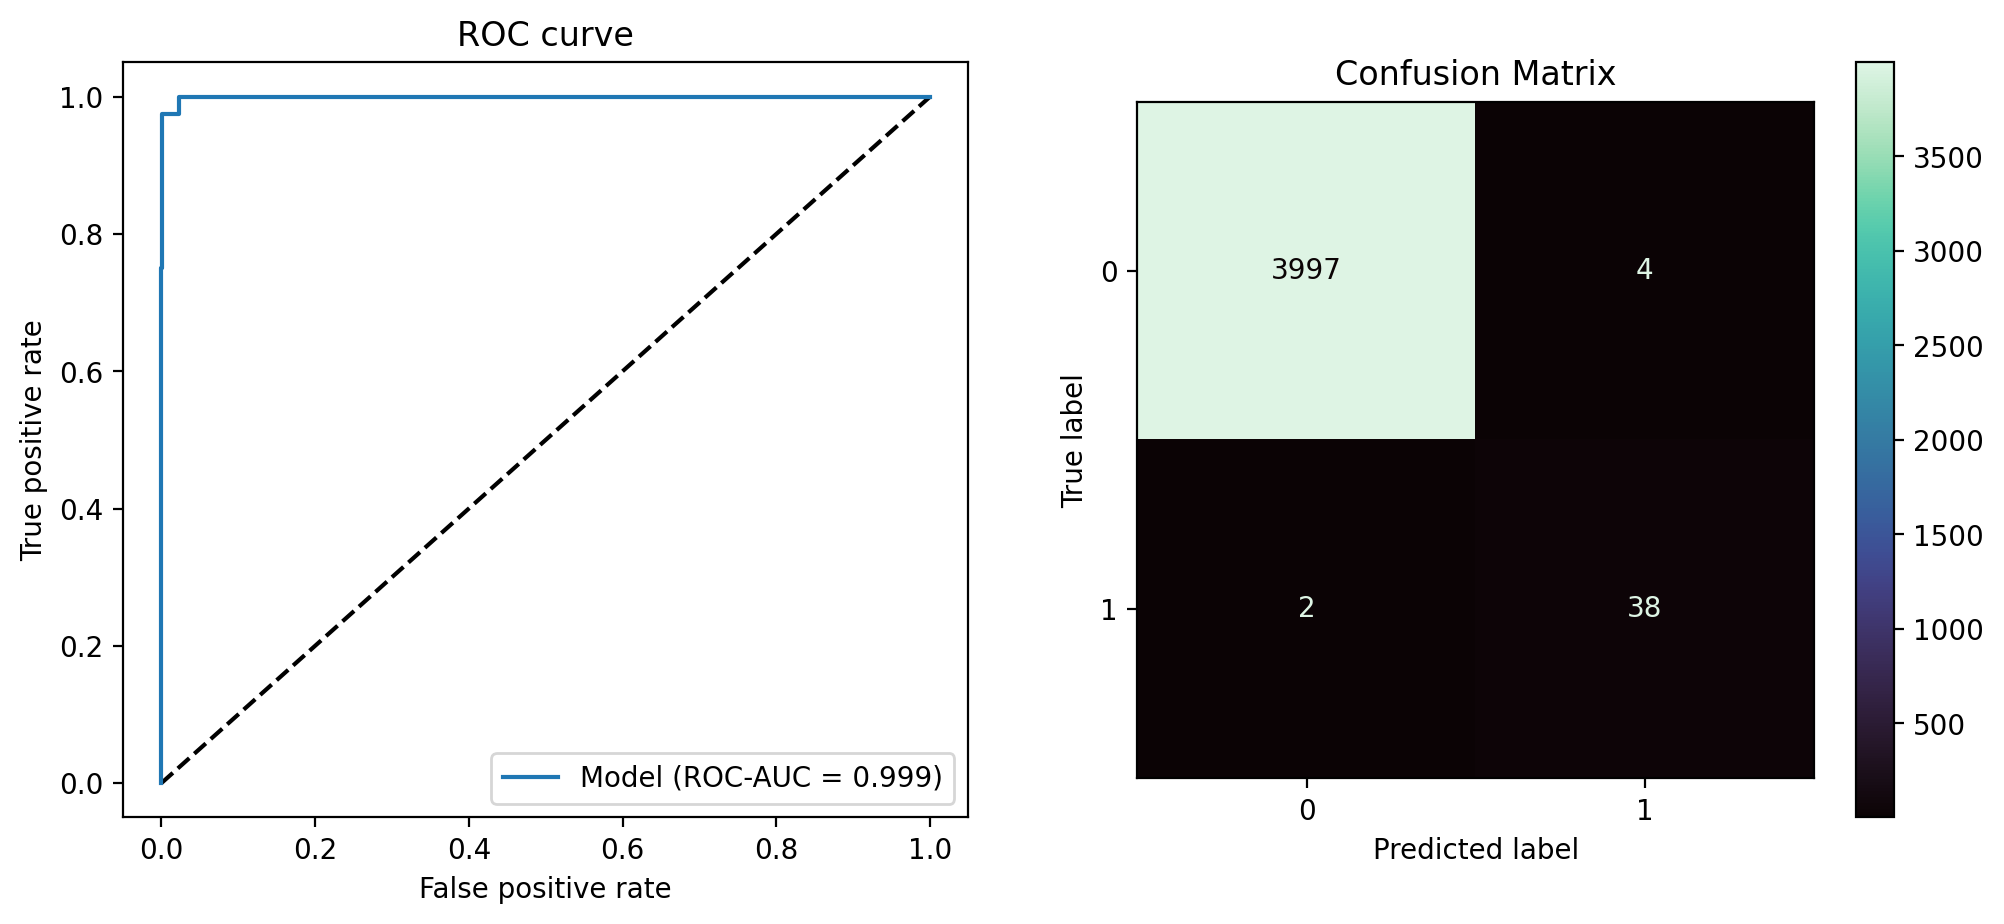

In [27]:
supervised_test.test()

# Target data

In [28]:
!unzip -q -no ../input/lensing-data-xploration/hsc2.zip
!unzip -q -no ../input/lensing-data-xploration/hsc_lens_candidates.zip

caution:  both -n and -o specified; ignoring -o
caution:  both -n and -o specified; ignoring -o


In [29]:
df= pd.read_csv("../input/lensing-data-xploration/Final_csv.csv")

In [30]:
test_df = df[df.fold == 0].reset_index(drop = True)
df = df[df.fold != 0].reset_index(drop = True)

In [31]:
s_data = Discriminator_dataset(X_train , train_aug)
t_data = Discriminator_dataset(df.values , train_aug,source = False)

tv_data = Len(test_df.values , val_aug)


In [32]:
s_loader = DataLoader(s_data, shuffle=True,
                        num_workers=4,
                        batch_size=100,drop_last = True)
t_loader = DataLoader(t_data, shuffle=True,
                        num_workers=4,
                        batch_size=100,drop_last =True)

tv_loader = DataLoader(tv_data, shuffle=False,
                        num_workers=4,
                        batch_size=100,drop_last =False)

In [33]:
s_encoder = ECNN()
s_encoder = s_encoder.to(device)

t_encoder = ECNN()
t_encoder = t_encoder.to(device)

classifier = Classifier()
classifier = classifier.to(device)

discriminator = Discriminator()
discriminator = discriminator.to(device)

s_encoder.load_state_dict(torch.load(best_encoder_path))
t_encoder.load_state_dict(torch.load(best_encoder_path))
classifier.load_state_dict(torch.load(best_classifier_path))

<All keys matched successfully>

In [34]:
adda_hpms = ADDA_HPAMS()

# Train

In [35]:
adda_train = ADDA_Train(s_loader,t_loader ,tv_loader, s_encoder , t_encoder , discriminator,classifier,adda_hpms,OUTPUT_DIR,device)

  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 1/5
average discriminative train_loss 1.3887902147629683
average target_loss 0.7147487794213435


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.07340325799880128
avarage val_auc 0.8589782418494569
avarage val_acc 0.981686541737649


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 2/5
average discriminative train_loss 1.3844012328807045
average target_loss 0.6843160458785646


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.07939408413686645
avarage val_auc 0.834491361089825
avarage val_acc 0.981686541737649


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 3/5
average discriminative train_loss 1.384298794409808
average target_loss 0.6897142288439414


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.0833964960366405
avarage val_auc 0.8266463461138425
avarage val_acc 0.9808347529812607


  0%|          | 0/272 [00:00<?, ?it/s]

For epoch 4/5
average discriminative train_loss 1.3848879622185932
average target_loss 0.6911042683264789


  0%|          | 0/81 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
    if w.is_alive():
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>


Traceback (most recent call last):
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/d

avarage val_loss 0.08119662728333557
avarage val_auc 0.835884307761989
avarage val_acc 0.9806218057921635


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>Traceback (most recent call last):
Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>
Traceback (most recent call last):

  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()
    Traceback (most recent call last):
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
      File "/opt/conda/lib/python3.

  0%|          | 0/272 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    Exception ignored in: Exception ignored in: Exception ignored in: self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710><function _MultiProcessingDataLoaderIter.__del__ at 0x7f9e0415f710>


  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1341, in _shutdown_workers
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
      File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/to

For epoch 5/5
average discriminative train_loss 1.383661084315356
average target_loss 0.6913367148269626


  0%|          | 0/81 [00:00<?, ?it/s]

avarage val_loss 0.08228659460811322
avarage val_auc 0.8342235723808149
avarage val_acc 0.9808347529812607


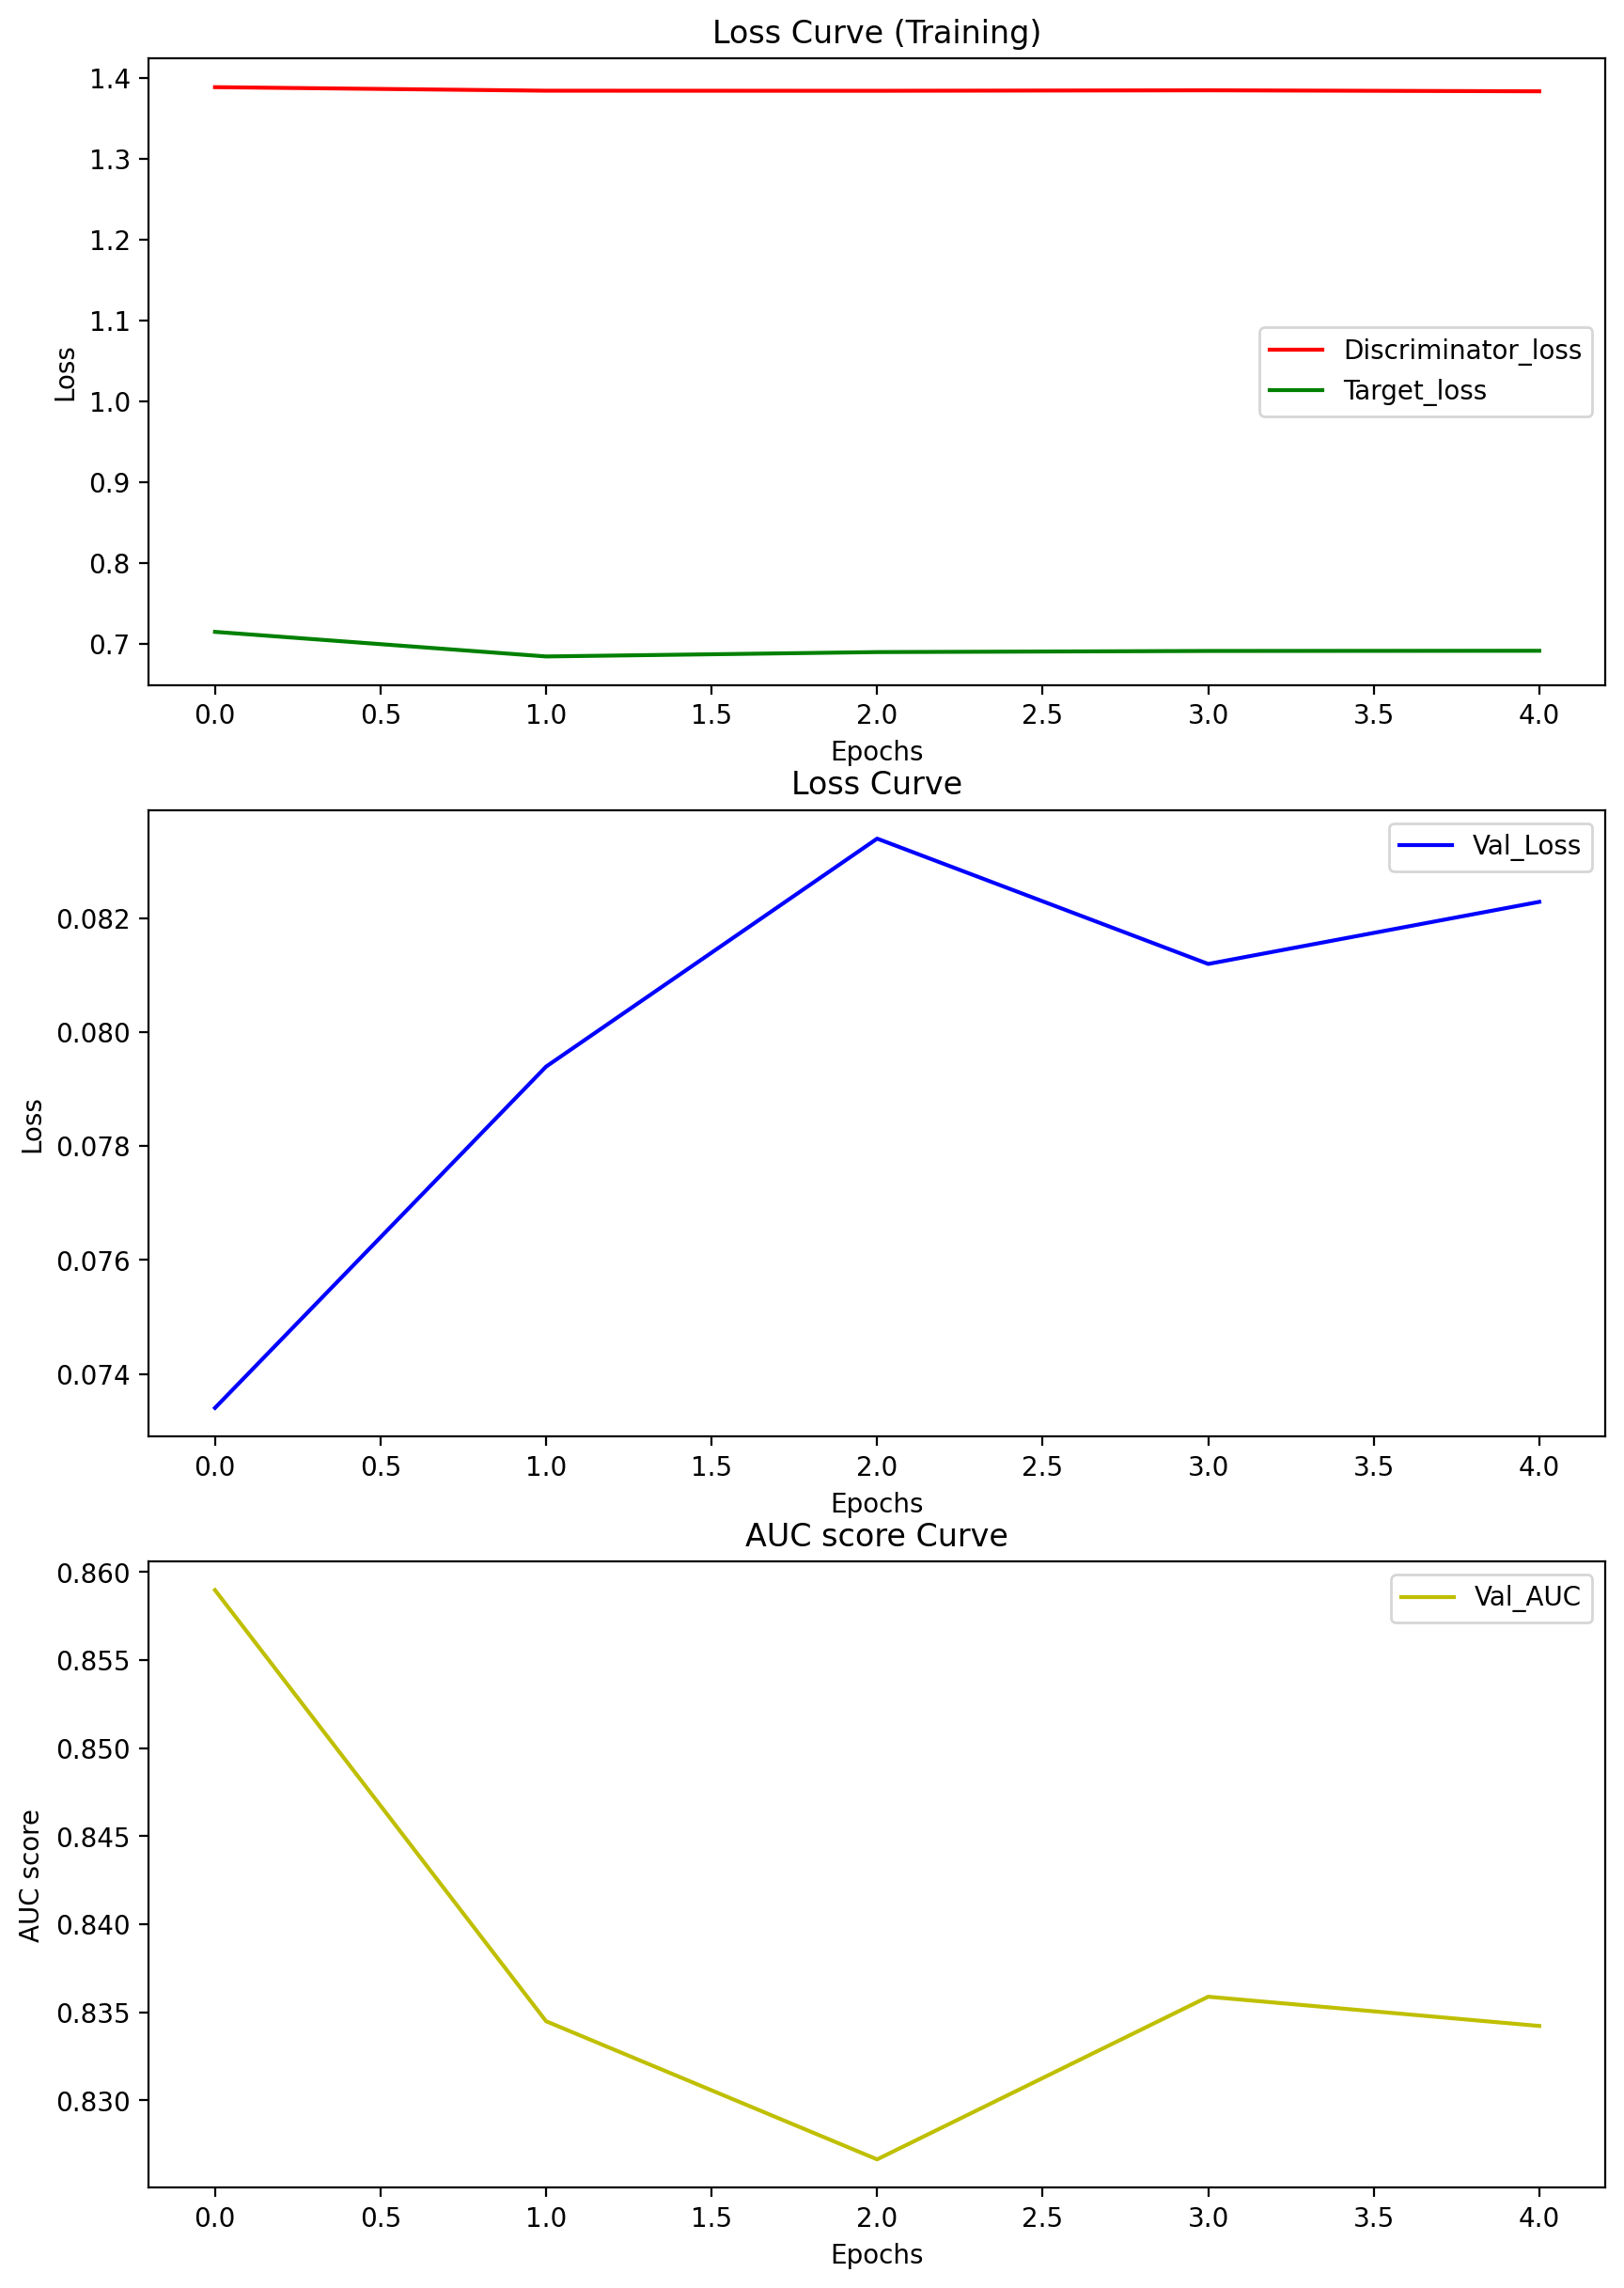

In [36]:
adda_train.train()

In [37]:
target_encoder_path = './Target_Encoder_val_auc 0.8589782418494569.pth'

# Test

  0%|          | 0/81 [00:00<?, ?it/s]

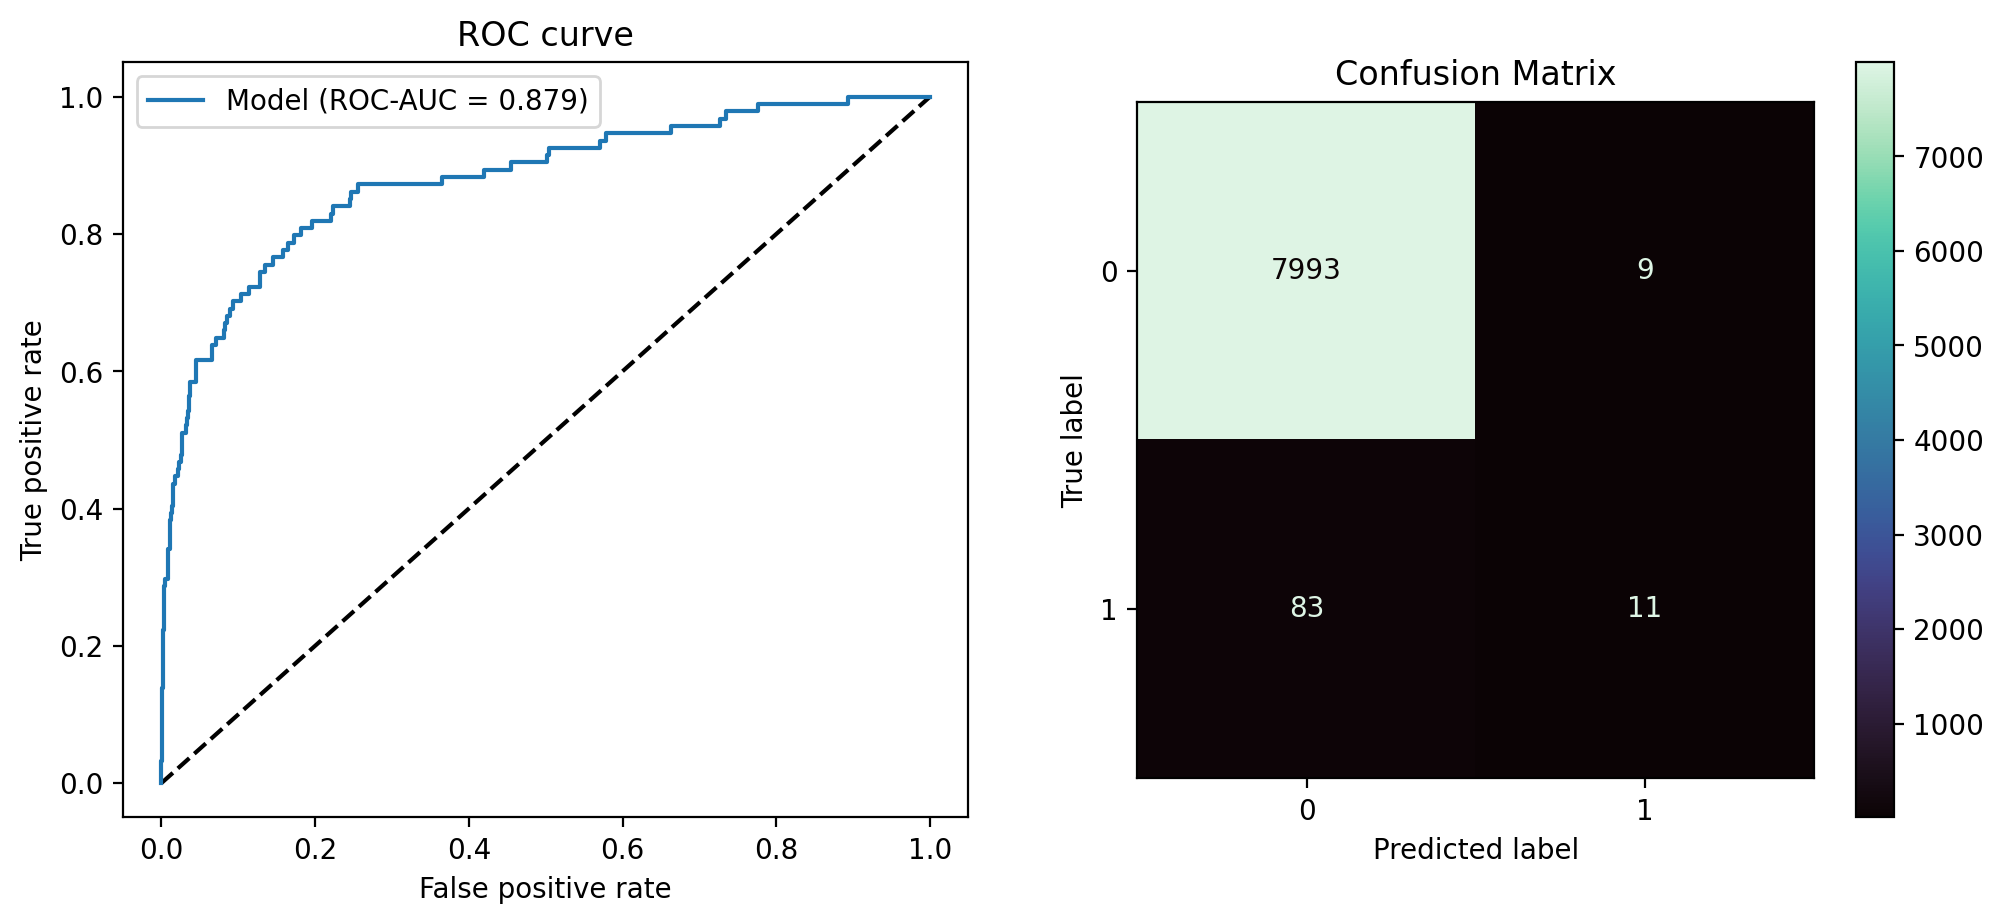

In [39]:
p,t = test_func(t_encoder,classifier,tv_loader ,device, target_encoder_path,best_classifier_path )
plot_test_metrics(p,t)